## Imports

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as pplt

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [8]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start, beta_start, gamma_start, rho_start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDeath"].to_numpy()
    print(dataDeath)
    time = np.linspace(offset,offset+len(data)-1, len(data))
    print(time)

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/1000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.034, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.020, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=500, tune=500, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

In [ ]:
def runMCMC(df, population, start_date, end_date, offset, beta, gamma, rho):
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    mcmc = sampleMCMC(offset,df,population, 3, beta, gamma, rho)
    return mcmc    

In [ ]:
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['i0','beta','gamma','rho','sigma'], round_to=5))
    return results

In [ ]:
def plotMCMC(model):
    plot = pm.plot_trace(model, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))
    return plot

In [14]:
dataSets = []
dataSets.two(pd.read_csv("../processed_data/cumDeathFrance.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathGermany.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathItaly.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathSpain.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathUK.csv"))

# Preparing Beta, Gamma, Rho values
beta = [0.3, 0.32, 0.34, 0.36]
gamma = [0.3, 0.32, 0.34, 0.36]
rho = [0.3, 0.32, 0.34, 0.36]

## Preparing 

In [ ]:

#dates and offsets for first quarantine
quarantine_one_offsets = []
quarantine_one_dates = []
quarantine_one_population = []

#France
quarantine_one_offsets.append()
quarantine_one_dates.append()
quarantine_one_population.append()

#Germany
quarantine_one_offsets.append()
quarantine_one_dates.append()
quarantine_one_population.append()

#Italy
quarantine_one_offsets.append()
quarantine_one_dates.append()
quarantine_one_population.append()

#Spain
quarantine_one_offsets.append()
quarantine_one_dates.append()
quarantine_one_population.append()

#UK
quarantine_one_offsets.append()
quarantine_one_dates.append()
quarantine_one_population.append()


In [ ]:
# file names, dates and and offsets for second quarantine
quarantine_two_offsets = []
quarantine_two_dates = []
quarantine_two_population = []


#France
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Germany
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Italy
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Spain
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#UK
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

## Running Analysis

In [ ]:
# Begin loop to run all the analysis on the first quarantine
quarantine_one_results = []
count = 0
for index, dataframe in enumerate(dataSets):
    run = True
    while run:
        try:
            quarantine_one_results.append(runMCMC(dataframe,quarantine_one_population[index],quarantine_one_dates[index][0],quarantine_one_dates[index][1],quarantine_one_offsets[index],
                                        beta[count], gamma[count], rho[count]))
        except:
            if (count < 6):
                count = count + 1 
            else:
                run = False
                next

# Begin loop to run all the analysis on the second quarantine
quarantine_two_results = []
for index, dataframe in enumerate(dataSets):
    try:
        quarantine_two_results.append(runMCMC(dataframe,quarantine_two_population[index],quarantine_two_dates[index][0],quarantine_two_dates[index][1],quarantine_two_offsets[index]))
    except:
        next


## Plotting Results

In [ ]:
# Plotting all results of the first set of quarantines
for result in quarantine_one_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))
    
# Plotting all results of the second set of quarantines
for result in quarantine_two_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))

## Data Visualization

In [35]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

shapefile = "/Users/zenodeangeli/Desktop/IndividualProject/data/ne_110m_admin_0_countries.shp"
geo_df = gpd.read_file(shapefile)

/Users/zenodeangeli/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(30.0, 70.0)

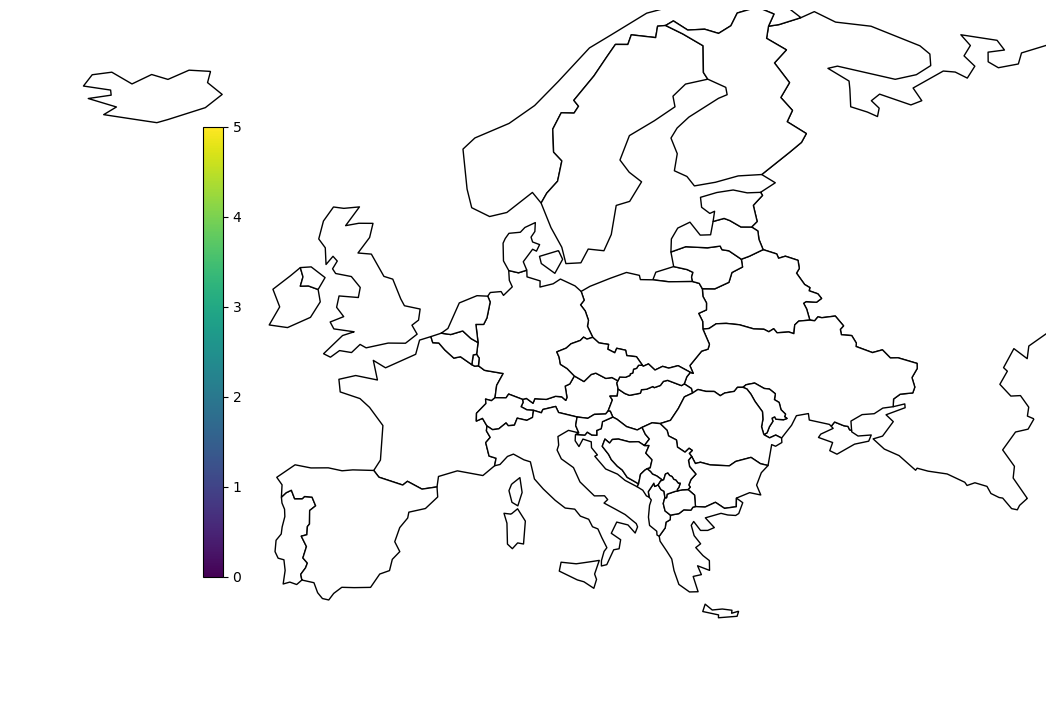

In [58]:
# General Information
country_list = ["Italy", "United Kindgom", "Spain", "Switzerland", "France", "Germany"]
vmin = 0
vmax = 5
col = "Example"
fig, ax = plt.subplots(1, figsize=(20, 9))
ax.axis('off')
africa_map_df = geo_df[geo_df['NAME'].isin(country_list)]

# Plotting the desired continent
geo_df[(geo_df["CONTINENT"] == "Europe")].plot(column=col, ax=ax, color='white', edgecolor='black')

# Adding Cmap to 
cmap = 'viridis'
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

# Setting Axis limits
ax.set_xlim(-30, 50)
ax.set_ylim(30, 70)